# Piotr Sotniczuk HW5 - dataset diabetes

In [102]:
import matplotlib.pyplot as plt
import seaborn as sb

In [103]:
from sklearn.datasets import load_diabetes
loaded = load_diabetes(as_frame=True)
X = loaded['data']
Y = loaded['target']

In [104]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, random_state=15, test_size=0.1)

Lets look into correlation matrix, it will be useful later.

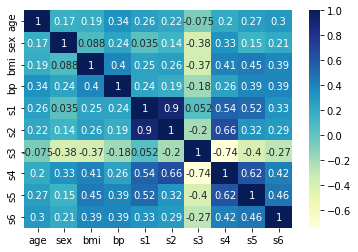

In [105]:
dataplot = sb.heatmap(X.corr(), cmap="YlGnBu", annot=True)
plt.show()

s1 and s2 are strongly correlated.

# This time I used RandomForest

In [107]:
from sklearn.ensemble import RandomForestRegressor

In [108]:
model = RandomForestRegressor(random_state=0).fit(x_train, y_train)

In [109]:
x_test.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
324,0.030811,-0.044642,0.005650,0.011544,0.078236,0.077913,-0.043401,0.108111,0.066048,0.019633
220,0.023546,0.050680,-0.039618,-0.005671,-0.048351,-0.033255,0.011824,-0.039493,-0.101644,-0.067351
67,0.041708,0.050680,-0.014828,-0.017147,-0.005697,0.008394,-0.013948,-0.001854,-0.011901,0.003064


# Does it work?
I plotted test set and predictions.

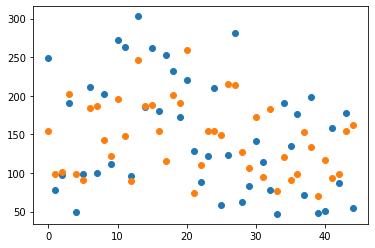

In [110]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(x_test)

plt.plot(range(y_test.size), y_test, linestyle = 'None', marker="o")
plt.plot(range(y_test.size), y_pred, linestyle = 'None', marker="o")

Plotted differences.

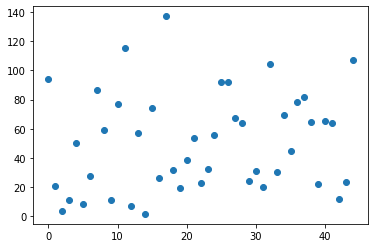

In [111]:
plt.plot(range(y_test.size), abs(y_test-y_pred), linestyle = 'None', marker="o")

I also calculated mean absolute error. It seems about right.

In [112]:
mean_absolute_error(y_test, y_pred)

50.67111111111111

I will count R^2 to have reference to other models.

In [113]:
model.score(x_test, y_test)

0.318265121634553

# Permutational variable importance in Random Forest

In [114]:
from sklearn.inspection import permutation_importance

In [115]:
r = permutation_importance(model, x_test, y_test, random_state=0)
r_train = permutation_importance(model, x_train, y_train, random_state=0)

Features in Random Forest on test and train sets.

In [116]:
# function from sklearn
def print_features(r, r_train):
    for i in r.importances_mean.argsort()[::-1]:
        print(f"{loaded.feature_names[i]:<8}"
            "test=" + f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}"
            "  train=" + f"{r_train.importances_mean[i]:.3f}"
            f" +/- {r_train.importances_std[i]:.3f}")

print_features(r, r_train)

s5      test=0.176 +/- 0.088  train=0.520 +/- 0.029
bmi     test=0.151 +/- 0.072  train=0.492 +/- 0.042
bp      test=0.068 +/- 0.018  train=0.118 +/- 0.007
sex     test=0.008 +/- 0.012  train=0.016 +/- 0.001
s3      test=-0.006 +/- 0.019  train=0.067 +/- 0.005
age     test=-0.017 +/- 0.012  train=0.084 +/- 0.006
s4      test=-0.019 +/- 0.008  train=0.019 +/- 0.001
s2      test=-0.030 +/- 0.019  train=0.070 +/- 0.003
s6      test=-0.046 +/- 0.005  train=0.099 +/- 0.007
s1      test=-0.047 +/- 0.018  train=0.047 +/- 0.003


On train set features have higher importance. On test set s6 has 9-th importance but on train set 4-th, this looks like overfitting.

S1 is highly correlated with s2 and s4, when we permute them it may decrease importance on both of them. Lets remove correlated features maybe s1 will gain something.

In [117]:
x_train_2 = x_train.drop(['s1', 's4'], axis=1)
model_2 = RandomForestRegressor(random_state=0).fit(x_train_2, y_train)
x_test_2 = x_test.drop(['s1', 's4'], axis=1)
model_2.score(x_test_2, y_test)

0.39529979786390657

In [118]:
r_corr = permutation_importance(model_2, x_test_2, y_test, random_state=0)
def features_importance(r, x):
    for i in r.importances_mean.argsort()[::-1]:
        print(f"{x.columns[i]:<8}"
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

features_importance(r_corr, x_test_2)

s5      0.224 +/- 0.090
bmi     0.181 +/- 0.069
bp      0.084 +/- 0.018
s3      0.011 +/- 0.010
sex     0.009 +/- 0.010
age     -0.001 +/- 0.014
s2      -0.022 +/- 0.025
s6      -0.037 +/- 0.009


Not really, importance of s2 stayed the same.

# Linear Regression

Score for linear regression

In [119]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(x_train, y_train)
lin_reg.score(x_test, y_test)

0.4213879674442772

And feature importance

In [120]:
r_lin_reg = permutation_importance(lin_reg, x_test, y_test, random_state=0)
features_importance(r_lin_reg, x_test)

s1      0.560 +/- 0.192
s2      0.510 +/- 0.110
s5      0.421 +/- 0.124
bmi     0.149 +/- 0.075
bp      0.092 +/- 0.025
s3      0.058 +/- 0.041
s4      0.049 +/- 0.046
sex     0.045 +/- 0.047
age     -0.004 +/- 0.002
s6      -0.019 +/- 0.013


For this model s1 and s2 have very high importance, this is a bit strange because usualli in this dataset bmi and s5 are most important.

Lets see what happens when we remove s2

In [122]:
x_train_lr = x_train.drop(['s2'], axis=1)
x_test_lr = x_test.drop(['s2'], axis=1)
lr_2 = LinearRegression().fit(x_train_lr, y_train)
lr_2.score(x_test_lr, y_test)

0.4316133407835444

In [123]:
r_lr_2 = permutation_importance(lr_2, x_test_lr, y_test, random_state=0)
features_importance(r_lr_2, x_test_lr)

s5      0.188 +/- 0.083
bmi     0.158 +/- 0.076
bp      0.091 +/- 0.025
sex     0.041 +/- 0.045
s4      0.040 +/- 0.039
s3      -0.001 +/- 0.008
age     -0.005 +/- 0.002
s1      -0.006 +/- 0.053
s6      -0.019 +/- 0.012


Now this looks normal. Both s5 and bmi are back most important and s1 is back on its place.

# Lasso

Lasso from definition selects most important features, lets validate if permutation_importance() works as it should.

In [124]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(x_train, y_train)
lasso.score(x_test, y_test)

0.34003589435582915

In [125]:
r_lasso = permutation_importance(lasso, x_test, y_test, random_state=0)
features_importance(r_lasso, x_test)

bmi     0.212 +/- 0.040
s5      0.158 +/- 0.042
s6      0.000 +/- 0.000
s4      0.000 +/- 0.000
s3      0.000 +/- 0.000
s2      0.000 +/- 0.000
s1      0.000 +/- 0.000
bp      0.000 +/- 0.000
sex     0.000 +/- 0.000
age     0.000 +/- 0.000


Only bmi and s5 have any importance. Rest has importance 0.00, this seems about right for Lasso.

# Gaussian Process Regressor

Lets try something different as black box (I have no idea how this model works).

In [99]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor().fit(x_train, y_train)

In [126]:
r_gpr = permutation_importance(gpr, x_test, y_test, random_state=0)
features_importance(r_gpr, x_test)

s1      7973.678 +/- 1520.036
s2      6445.185 +/- 974.859
s3      837.768 +/- 130.584
s5      565.138 +/- 41.452
s4      78.197 +/- 49.148
bmi     3.138 +/- 0.686
s6      2.610 +/- 1.275
sex     1.019 +/- 0.759
age     0.844 +/- 0.710
bp      0.688 +/- 0.123


Hmm the s1 and s2 are skyrocketing this is rather strange. Maybe again because of correlation, lets try removing s1.

In [127]:
x_train_3 = x_train.drop(['s1'], axis=1)
x_test_3 = x_test.drop(['s1'], axis=1)
gpr_2 = GaussianProcessRegressor(random_state=0).fit(x_train_3, y_train)
r_gpr_2 = permutation_importance(gpr_2, x_test_3, y_test, random_state=0)
features_importance(r_gpr_2, x_test_3)

s4      86.979 +/- 50.456
s3      19.994 +/- 7.766
s2      5.772 +/- 1.958
s5      5.031 +/- 0.992
bmi     1.859 +/- 0.463
s6      0.949 +/- 0.647
sex     0.887 +/- 0.549
bp      0.506 +/- 0.235
age     0.119 +/- 0.398


It looks better but why s4 and s3 are so important? Also standard error is pretty high.
Lets check scores of those models.

In [128]:
print("first model = ", gpr.score(x_test, y_test))

first model =  -2.059013322254135


In [129]:
print("second model = ", gpr_2.score(x_test_3, y_test))

second model =  -1.4704958962367618


They behave strange because the models are not really working. Both of them have R^2 score less than 0 which means they work worse than a constant model.